### Bibliothèque

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np

sys.path.append("../python")

from data import Dataloader
from models import TwoClustersMIP, HeuristicModel
import metrics

### TwoClustersMIP

In [2]:
# Loading the data
data_loader = Dataloader("../data/dataset_4") # Specify path to the dataset you want to load
X, Y = data_loader.load()

In [3]:
# Let's train an example model
model = TwoClustersMIP(5,2) # Instantiation of the model with hyperparameters, if needed
model.fit(X, Y) # Training of the model, using preference data

Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-11
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 23.2.0 23C71)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1250 rows, 2448 columns and 15256 nonzeros
Model fingerprint: 0xd4ce7bd9
Variable types: 1648 continuous, 800 integer (800 binary)
Coefficient statistics:
  Matrix range     [6e-06, 3e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 3e+00]
Found heuristic solution: objective 38.0596509
Presolve removed 416 rows and 1608 columns
Presolve time: 0.01s
Presolved: 834 rows, 840 columns, 10814 nonzeros
Found heuristic solution: objective 31.2147262
Variable types: 440 continuous, 400 integer (400 binary)

Root relaxation: objective 0.000000e+00, 231 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds    

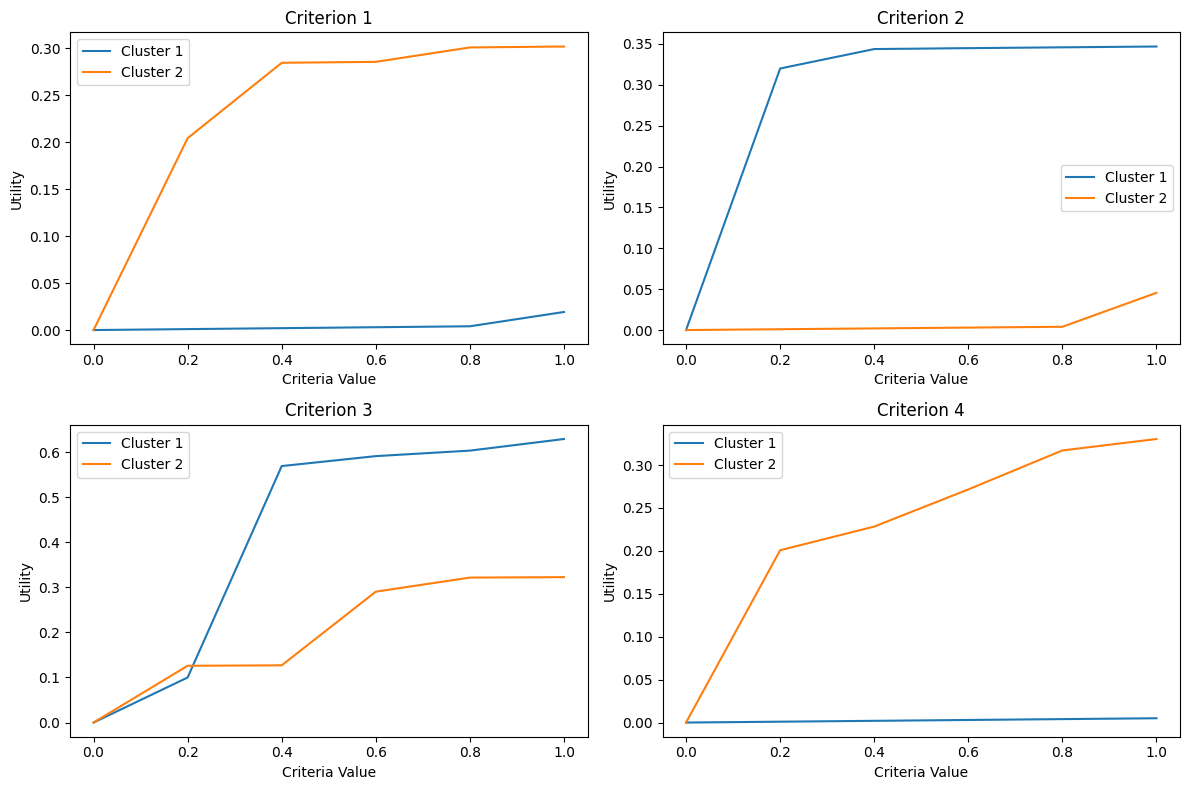

In [4]:
n = 4
K = 2
L = 6

u = {
    f"U_{i}_{k}": [] for i in range(n) for k in range(K)
}
for i in range(n):
    for k in range(K):
        for l in range(L):
            u[f"U_{i}_{k}"].append(model.u[(i, k, l)].X)

Abscisses=[0,0.2,0.4,0.6,0.8,1]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Plotting
for i in range(n):
    x, y = i // 2, i % 2
    for k in range(K):
        axs[x, y].plot(Abscisses, u[f"U_{i}_{k}"], label=f"Cluster {k+1}")
    axs[x, y].set_title(f"Criterion {i+1}")
    axs[x, y].set_xlabel("Criteria Value")
    axs[x, y].set_ylabel("Utility")
    axs[x, y].legend()

plt.tight_layout()
plt.show()


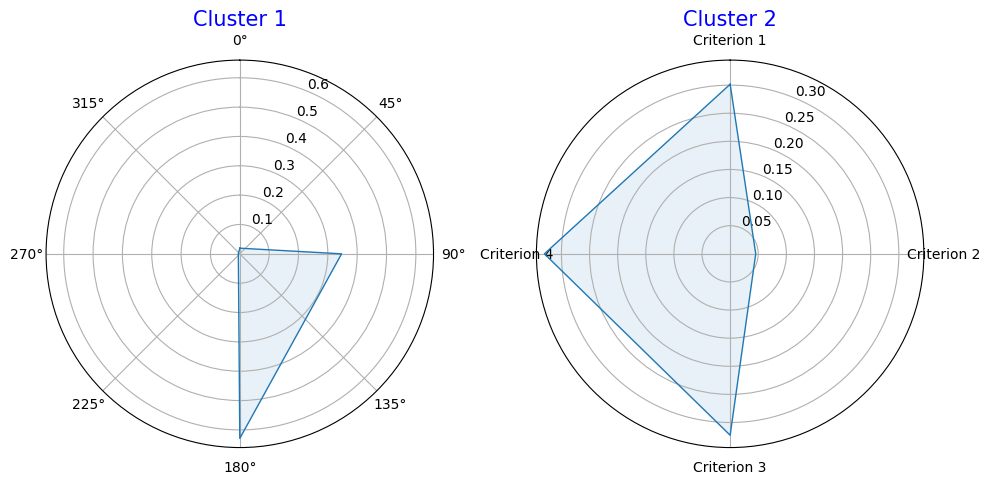

In [5]:
from math import pi
import numpy as np

# Extracting the last value for each criterion and cluster to represent the importance of each criterion
importance = {
    "Cluster 1": [u[f"U_{i}_0"][-1] for i in range(n)],
    "Cluster 2": [u[f"U_{i}_1"][-1] for i in range(n)]
}

# Number of variables we're plotting.
categories = [f"Criterion {i+1}" for i in range(n)]
N = len(categories)

# What will be the angle of each axis in the plot? (divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # Completing the loop

# Initialise the radar plot
fig, ax = plt.subplots(nrows=1, ncols=2, subplot_kw=dict(polar=True), figsize=(10, 5))

# Draw one axe per variable + add labels
for ax_i, cluster in zip(ax, importance.keys()):
    ax_i.set_theta_offset(pi / 2)
    ax_i.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories)

    # Plot data
    values = importance[cluster]
    values += values[:1]
    ax_i.plot(angles, values, linewidth=1, linestyle='solid', label=cluster)
    ax_i.fill(angles, values, alpha=0.1)

    # Add a title
    ax_i.set_title(cluster, size=15, color='blue', position=(0.5, 1.1))

plt.tight_layout()
plt.show()


In [6]:
X[:5]

array([[0.45360563, 0.25691407, 0.71509031, 0.90380217],
       [0.83007226, 0.03330589, 0.51154491, 0.33237916],
       [0.89127263, 0.22972051, 0.20723437, 0.38867979],
       [0.34810015, 0.14370209, 0.84365555, 0.15995849],
       [0.70778793, 0.40422988, 0.06496445, 0.21603425]])

In [7]:
# Or we can directly use the predict_preference method:
print(model.predict_preference(X, Y)[:5]) # For each cluster we see if X is preferred to Y (0) or the contrary (1)
# predict_preference returns preference of samples for each cluster, returning shape (n_samples, n_clusters)
# 0 means that the cluster prefers first argument (here X[i]), 1 means that the cluster prefers second argument (here Y[i])

[[0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]]


In [8]:
# We consider that our model explains our data, if for at least one cluster, X[i] >> Y[i]
pairs_explained = np.sum(model.predict_preference(X, Y)[:5] == 0, axis=1) # For each sample check if each clusters prefers X[i] (then is True)
pairs_explained = pairs_explained > 0 # If at least one cluster prefers X[i], then X[i] >> Y[i] is explained
print("Percentage of explained preferences for 5 first samples:", np.sum(pairs_explained) / 5) # Get % or explained pairs

Percentage of explained preferences for 5 first samples: 1.0


In [9]:
# Or we call directly the right metric:
pairs_explained = metrics.PairsExplained()
print("Percentage of explained preferences for all samples:", pairs_explained.from_model(model, X, Y))
# Or other possibility:
print("Percentage of explained preferences for all samples:", pairs_explained(model.predict_utility(X), model.predict_utility(Y)))

Percentage of explained preferences for all samples: 0.951
Percentage of explained preferences for all samples: 0.951


In [10]:
# Now, we can also see how our model clusters our data
print(model.predict_cluster(X, Y)[:5]) # Returns for each sample which cluster is the most likely to have generated the preference.
# The most likely cluster is the one with the highest utility difference U(X[i])-U(Y[i]) for the sample.

[1 1 1 0 1]


In [11]:
# Ground truth are also provided:
Z = data_loader.get_ground_truth_labels()
# We can see how it compares to our model's predictions:
print(Z[:5])

[0 0 0 1 0]


In [12]:
# We have a metric to calculate how well the model has regrouped the preferences pairs compared to ground truth:
cluster_intersection = metrics.ClusterIntersection()

print("Cluster intersection for 5 first samples:", cluster_intersection(model.predict_cluster(X, Y)[:5], Z[:5]))

# Then for all data:
print("Cluster intersection for all samples:", cluster_intersection(model.predict_cluster(X, Y), Z))
print("Cluster intersection for all samples:", cluster_intersection.from_model(model, X, Y, Z))

Cluster intersection for 5 first samples: 1.0
Cluster intersection for all samples: 0.9753001500750376
Cluster intersection for all samples: 0.9753001500750376


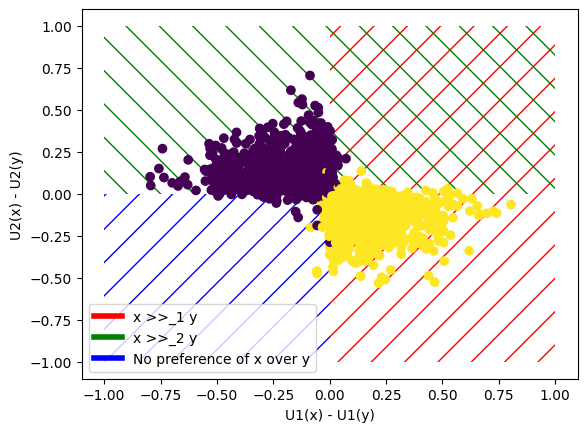

In [13]:
# Here is a proposition of a useful plot to see how the model clusters the data:
# We look at how each cluster evaluates U(x) - U(y) and color with ground truth clustering
# Note that x >>_1 y means that x is preferred to y for cluster 1
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

plt.figure()
plt.xlabel("U1(x) - U1(y)")
plt.ylabel("U2(x) - U2(y)")

plt.gca().add_patch(Rectangle((0,-1.),1., 2.,
                    edgecolor='red',
                    facecolor='none',
                    lw=0, 
                    hatch='/'))
plt.gca().add_patch(Rectangle((-1.,0), 2., 1.,
                    edgecolor='green',
                    facecolor='none',
                    lw=0, 
                    hatch='\\'))
plt.gca().add_patch(Rectangle((-1.,-1.),1., 1.,
                    edgecolor='blue',
                    facecolor='none',
                    hatch='/',
                    lw=0))
plt.scatter(model.predict_utility(X)[:, 0]-model.predict_utility(Y)[:, 0], 
            model.predict_utility(X)[:, 1]-model.predict_utility(Y)[:, 1], c=Z)

custom_lines = [Line2D([0], [0], color="red", lw=4),
                Line2D([0], [0], color="green", lw=4),
                Line2D([0], [0], color="b", lw=4)]

plt.legend(custom_lines, ['x >>_1 y', "x >>_2 y ", 'No preference of x over y'])
plt.show()

Our random model cannot explain a large part of our preference data. Your first assigment will be to write a Mixed-Interger Programming algorithm that will be able to do so.

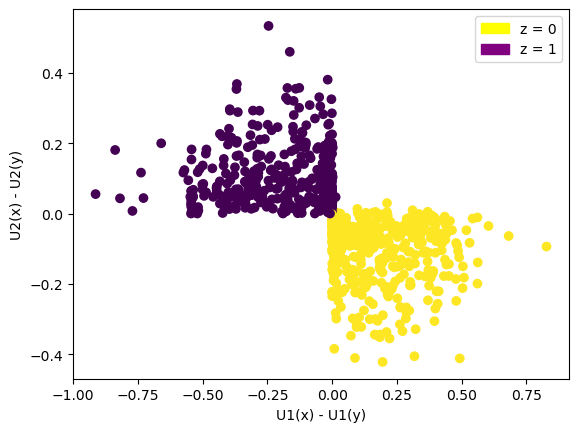

In [14]:
# As an example here are the results obtained with:
""" # Uncomment the code to check your results
plt.figure()
plt.scatter(model.predict_utility(X)[:, 0]-model.predict_utility(Y)[:, 0], 
            model.predict_utility(X)[:, 1]-model.predict_utility(Y)[:, 1], c=Z)
plt.xlabel("U1(x) - U1(y)")
plt.ylabel("U2(x) - U2(y)")
plt.show()
"""
# Here is how it should look like
from IPython.display import Image
Image("../images/MIP_results_example.png")

Your second assignement will be to find a model that will work well with larger data instances.

### Heuritic model

In [15]:
# Loading the data
data_loader = Dataloader("../data/dataset_10") # Specify path to the dataset you want to load
X, Y = data_loader.load()

In [16]:
# Let's train an example model
model = HeuristicModel(3) # Instantiation of the model with hyperparameters, if needed
model.fit(X, Y) # Training of the model, using preference data

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 23.2.0 23C71)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 13394 rows, 53392 columns and 491195 nonzeros
Model fingerprint: 0xd0842fdc
Coefficient statistics:
  Matrix range     [5e-06, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 1e+00]
Presolve removed 20 rows and 40009 columns
Presolve time: 0.26s
Presolved: 50 rows, 13384 columns, 389743 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.225e+03
 Factor NZ  : 1.275e+03 (roughly 5 MB of memory)
 Factor Ops : 4.292e+04 (less than 1 second per iteration)
 Threads    : 6

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   4.25403842e+04  4.484342

In [17]:
# Or we call directly the right metric:
pairs_explained = metrics.PairsExplained()
print("Percentage of explained preferences for all samples:", pairs_explained.from_model(model, X, Y))

Percentage of explained preferences for all samples: 0.8648067596620169


In [18]:
Z = data_loader.get_ground_truth_labels()

In [19]:
# We have a metric to calculate how well the model has regrouped the preferences pairs compared to ground truth:
cluster_intersection = metrics.ClusterIntersection()

print("Cluster intersection for 5 first samples:", cluster_intersection(model.predict_cluster(X, Y)[:5], Z[:5]))

# Then for all data:
print("Cluster intersection for all samples:", cluster_intersection(model.predict_cluster(X, Y), Z))
print("Cluster intersection for all samples:", cluster_intersection.from_model(model, X, Y, Z))

Cluster intersection for 5 first samples: 0.6
Cluster intersection for all samples: 0.6779572136115326
Cluster intersection for all samples: 0.6779572136115326


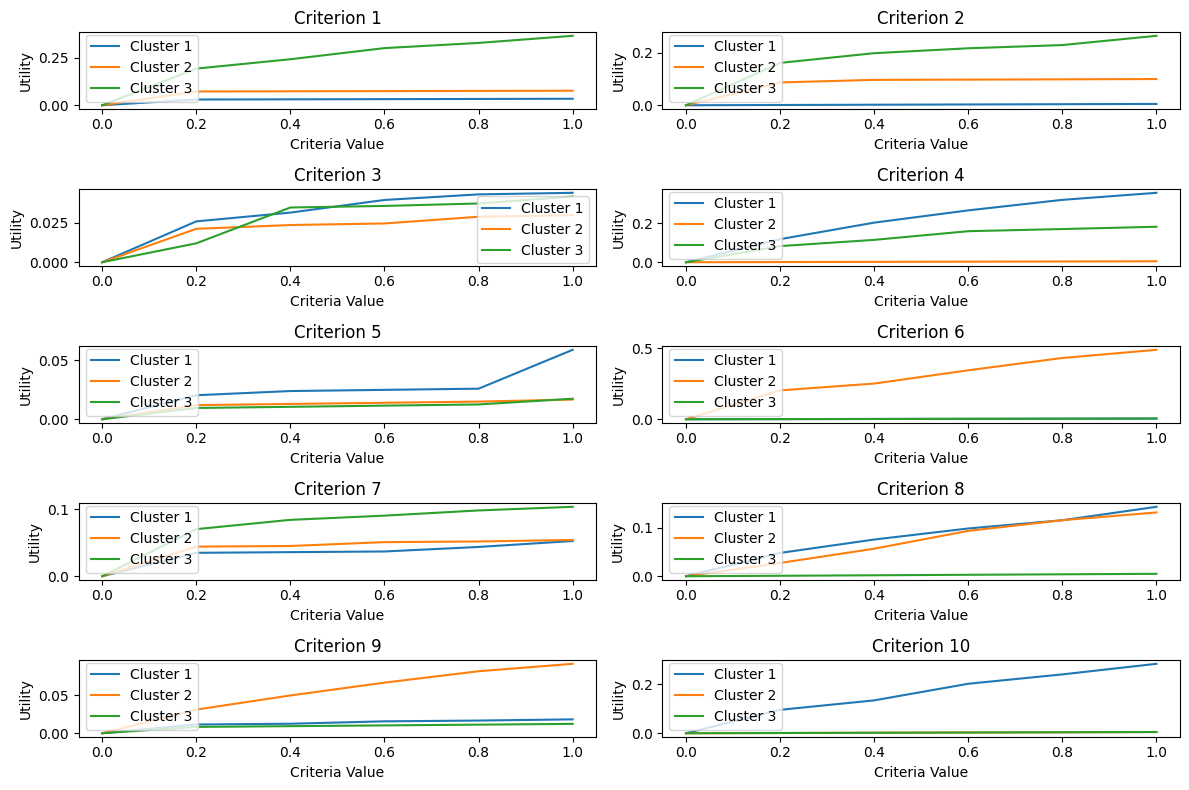

In [20]:
n = 10
K = 3
L = 6

u = {
    f"U_{i}_{k}": [] for i in range(n) for k in range(K)
}
for i in range(n):
    for k in range(K):
        for l in range(L):
            u[f"U_{i}_{k}"].append(model.u[(i, k, l)])

Abscisses=[0,0.2,0.4,0.6,0.8,1]

fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(12, 8))

# Plotting
for i in range(n):
    x, y = i // 2, i % 2
    for k in range(K):
        axs[x, y].plot(Abscisses, u[f"U_{i}_{k}"], label=f"Cluster {k+1}")
    axs[x, y].set_title(f"Criterion {i+1}")
    axs[x, y].set_xlabel("Criteria Value")
    axs[x, y].set_ylabel("Utility")
    axs[x, y].legend()

plt.tight_layout()
plt.show()


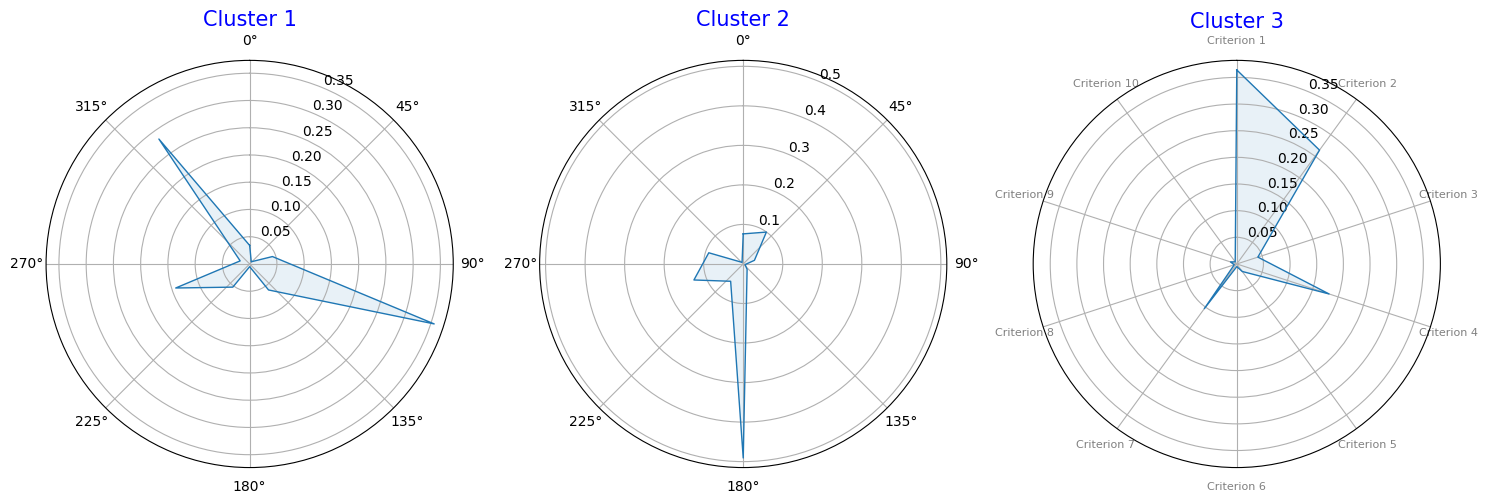

In [21]:
from math import pi
import numpy as np
import matplotlib.pyplot as plt

# Adaptation for 3 clusters and 10 criteria
n = 10  # Number of criteria
importance = {
    "Cluster 1": [u[f"U_{i}_0"][-1] for i in range(n)],
    "Cluster 2": [u[f"U_{i}_1"][-1] for i in range(n)],
    "Cluster 3": [u[f"U_{i}_2"][-1] for i in range(n)]
}

categories = [f"Criterion {i+1}" for i in range(n)]
N = len(categories)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # Completing the loop

fig, ax = plt.subplots(nrows=1, ncols=3, subplot_kw=dict(polar=True), figsize=(15, 5))

for ax_i, cluster in zip(ax, importance.keys()):
    ax_i.set_theta_offset(pi / 2)
    ax_i.set_theta_direction(-1)
    plt.xticks(angles[:-1], categories, color='grey', size=8)
    
    values = importance[cluster]
    values += values[:1]
    ax_i.plot(angles, values, linewidth=1, linestyle='solid', label=cluster)
    ax_i.fill(angles, values, alpha=0.1)
    ax_i.set_title(cluster, size=15, color='blue', position=(0.5, 1.1))

plt.tight_layout()
plt.show()
